##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.3.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

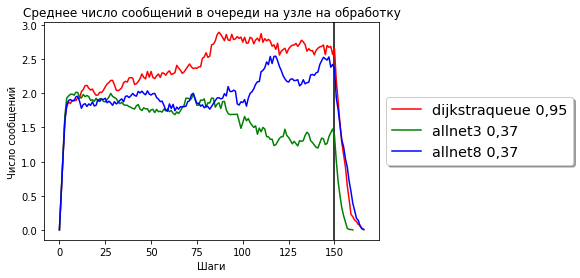

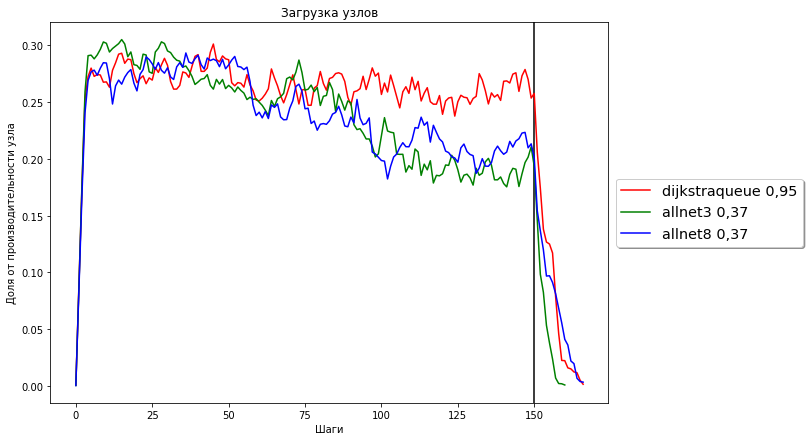

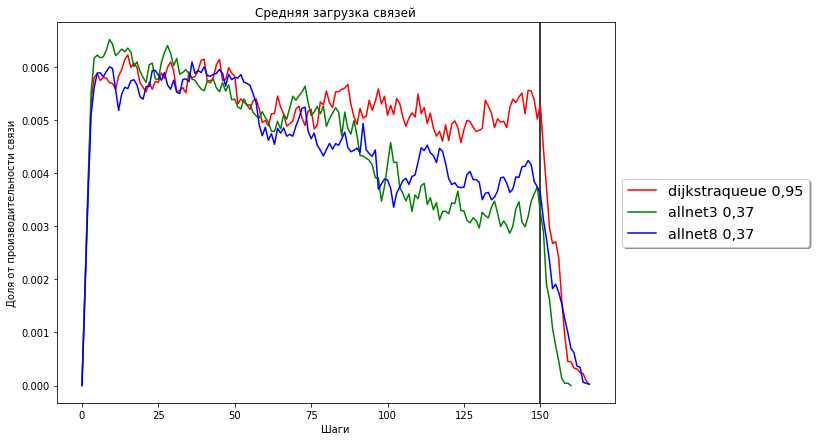

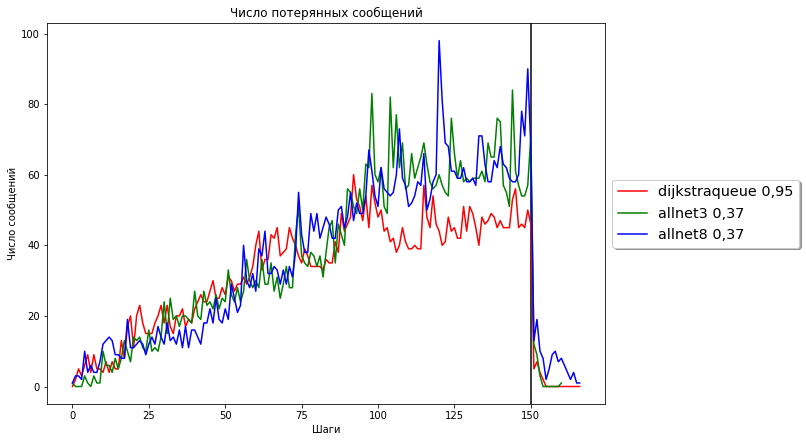

Доставлено 9946 Потеряно 33.6978% -dijkstraqueue 0,95
Доставлено 9256 Потеряно 38.2974% -allnet3 0,37
Доставлено 9109 Потеряно 39.2774% -allnet8 0,37


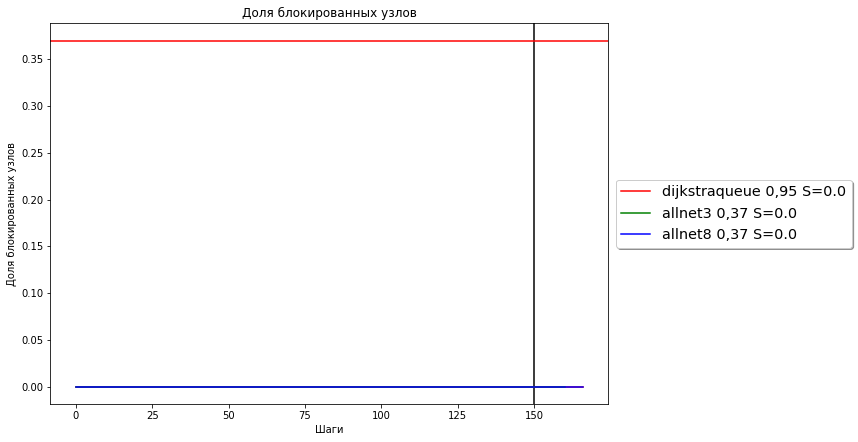

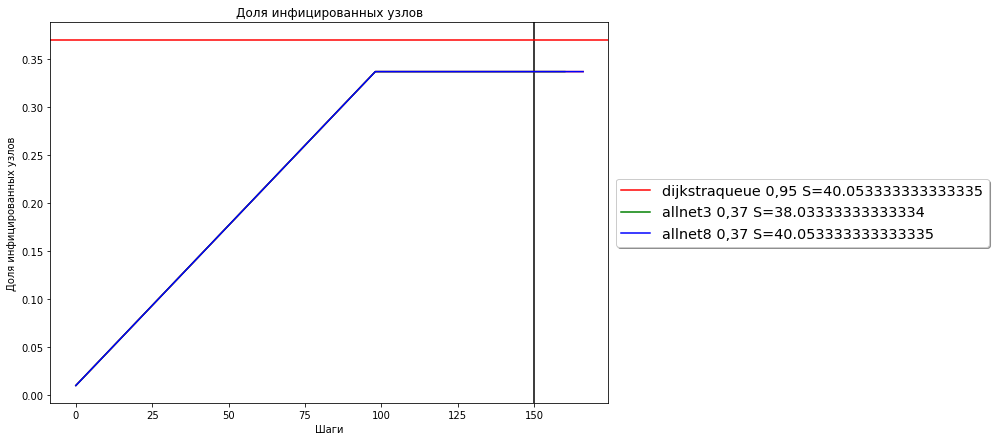

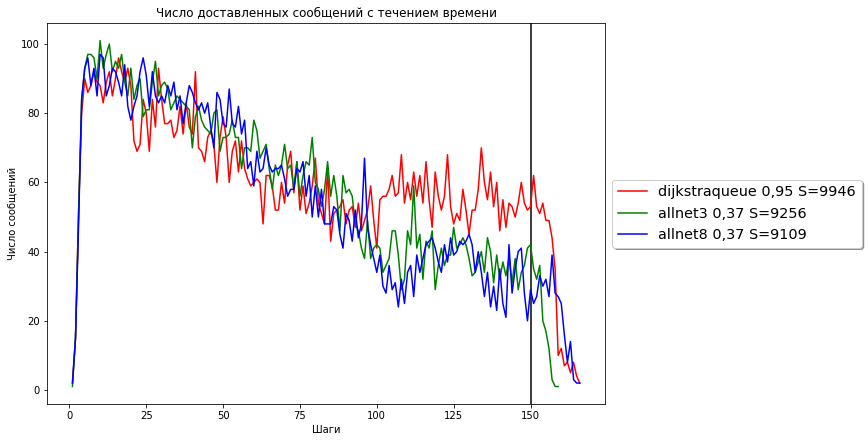

In [3]:
quantity = 100;
log_tags = [
{"tag":  "25b881b0-9422-40c0-9173-fe07f6dd34c7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e6b6c1c8-fbcb-446f-ab79-12600d0d6124", "label": "allnet3 0,37", "color": "green"},
{"tag":  "78c5adb0-0031-499c-8245-122727ab5d88", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 500 </strong>

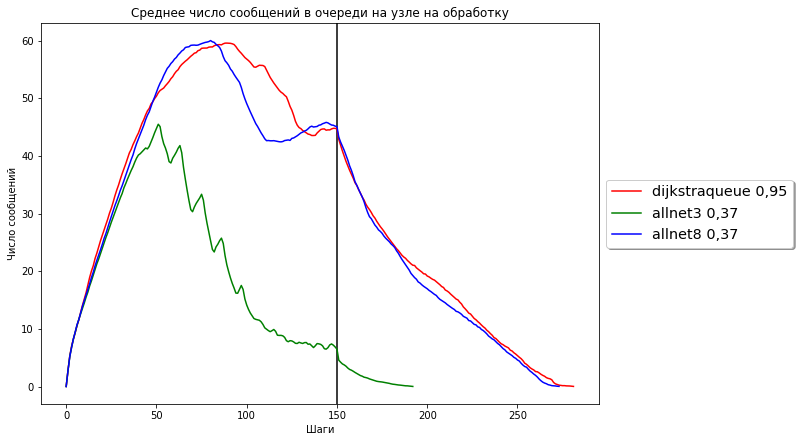

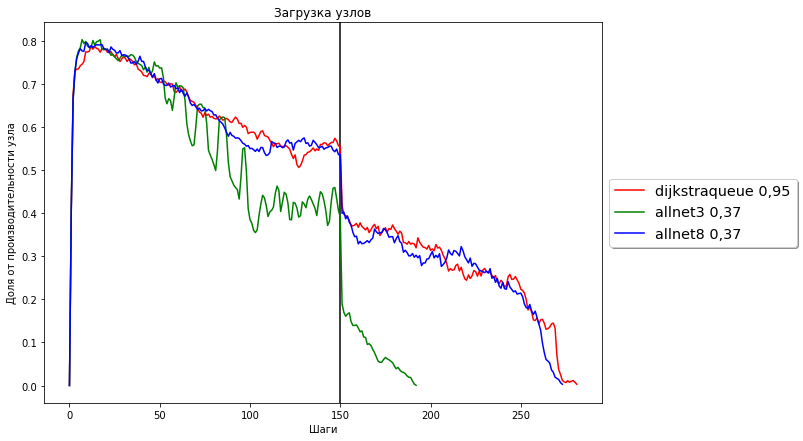

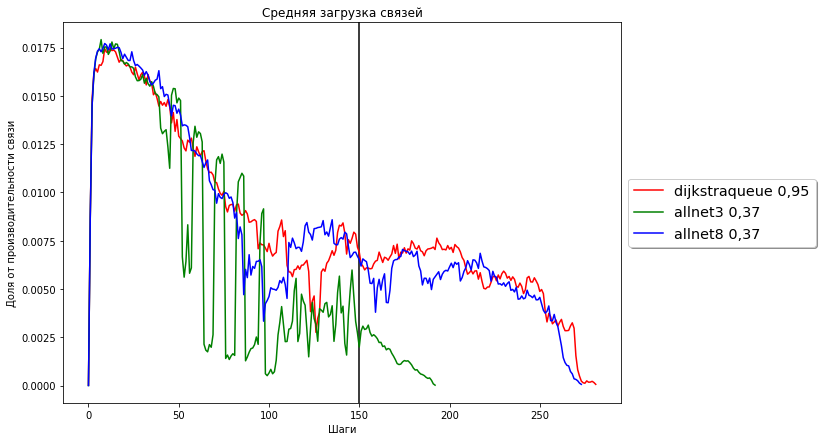

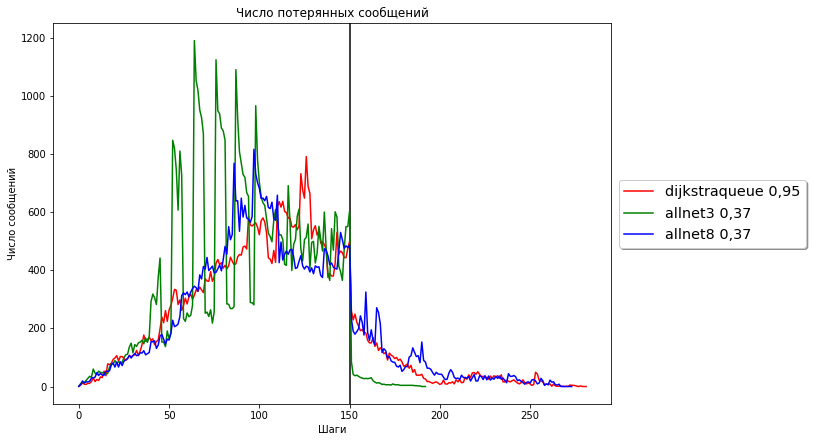

Доставлено 16866 Потеряно 77.5123% -dijkstraqueue 0,95
Доставлено 12198 Потеряно 83.7362% -allnet3 0,37
Доставлено 16438 Потеряно 78.0830% -allnet8 0,37


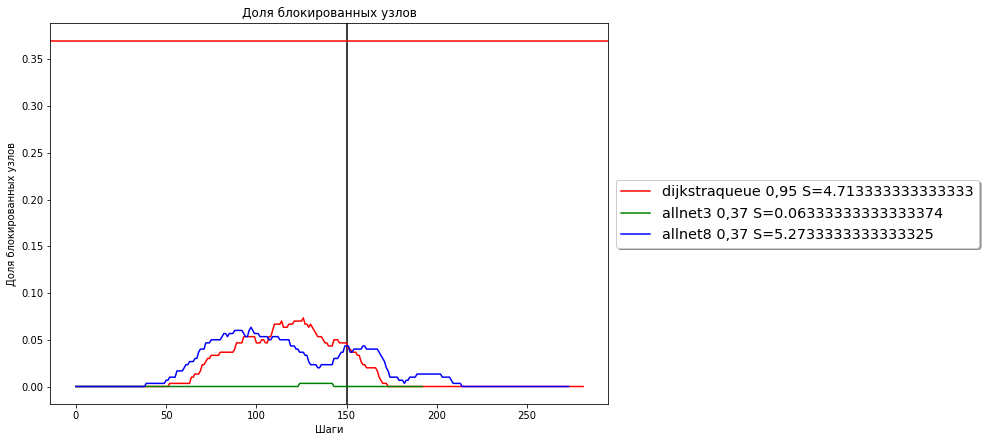

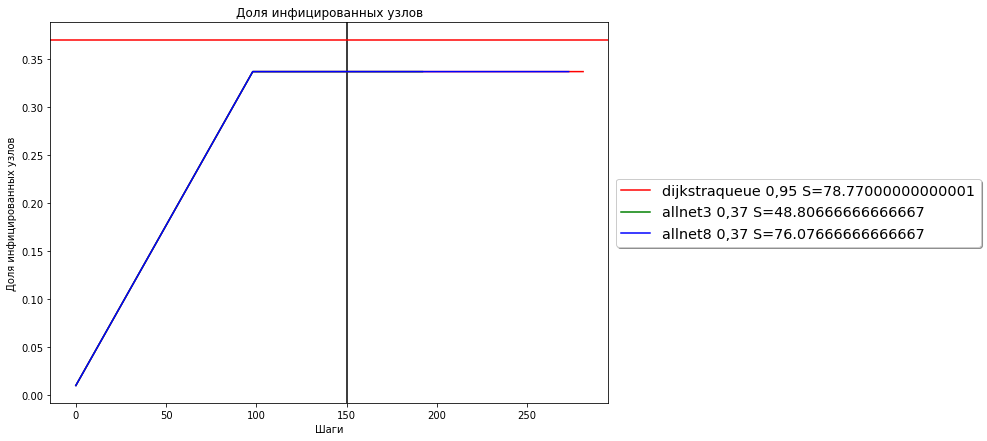

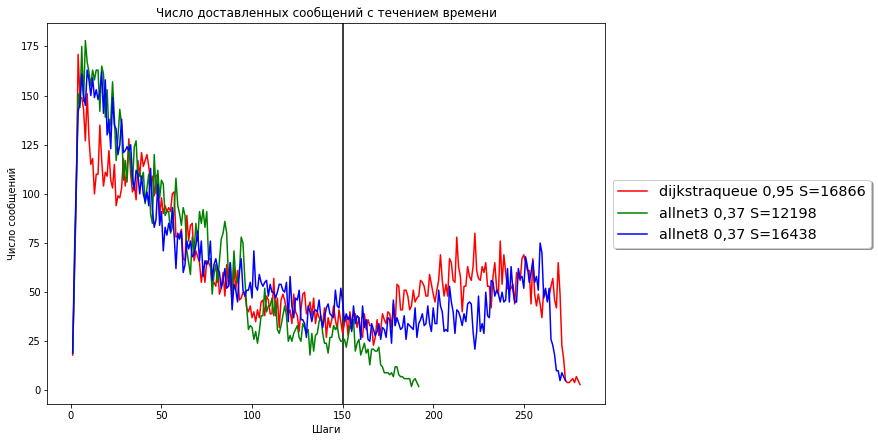

In [4]:
quantity = 500;
log_tags = [
{"tag":  "620fac56-2053-422e-8fc8-5f32ab351eee", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "87700e8b-fcb4-4f7e-93a0-8595243b6ed5", "label": "allnet3 0,37", "color": "green"},
{"tag":  "15b923fd-2543-4745-a5e4-45e9c42a8bce", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

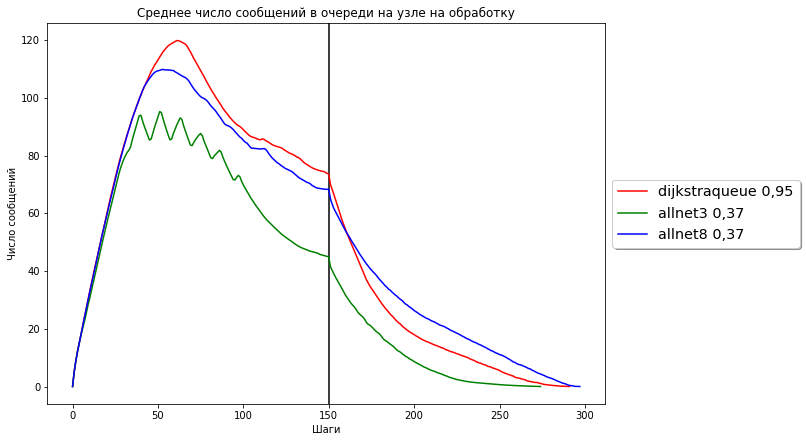

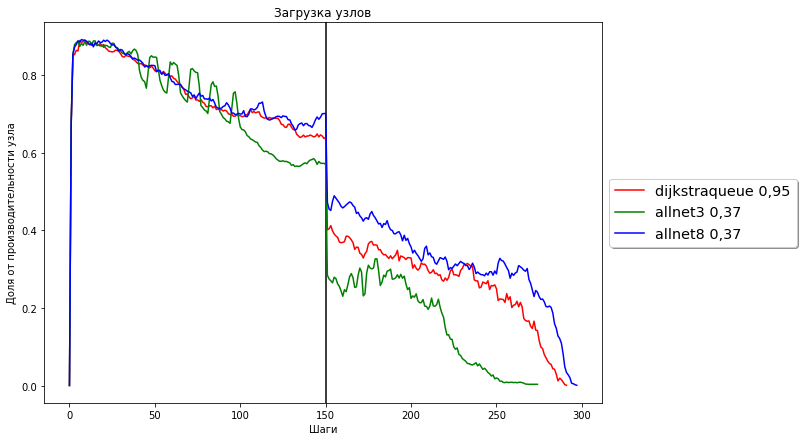

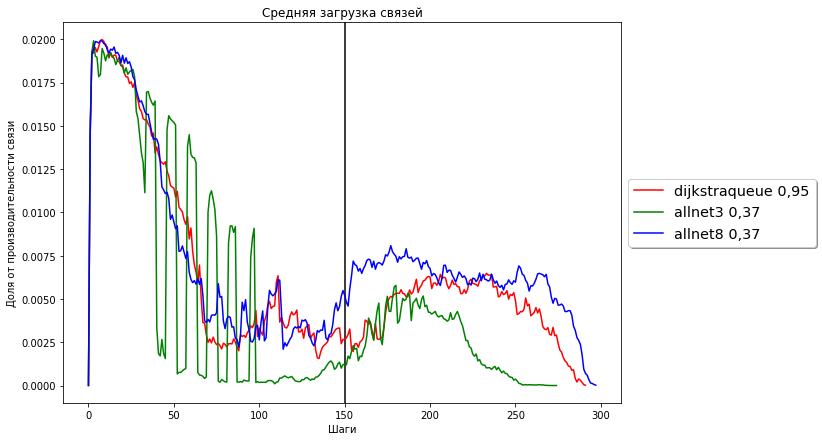

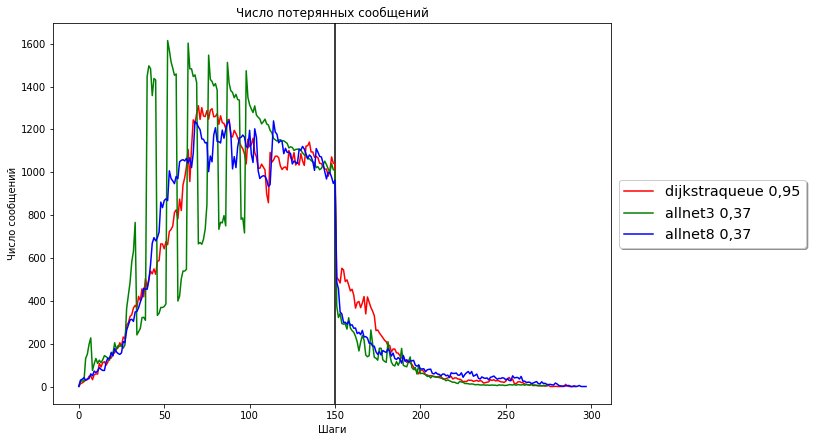

Доставлено 12479 Потеряно 91.6807% -dijkstraqueue 0,95
Доставлено 9124 Потеряно 93.9174% -allnet3 0,37
Доставлено 13905 Потеряно 90.7301% -allnet8 0,37


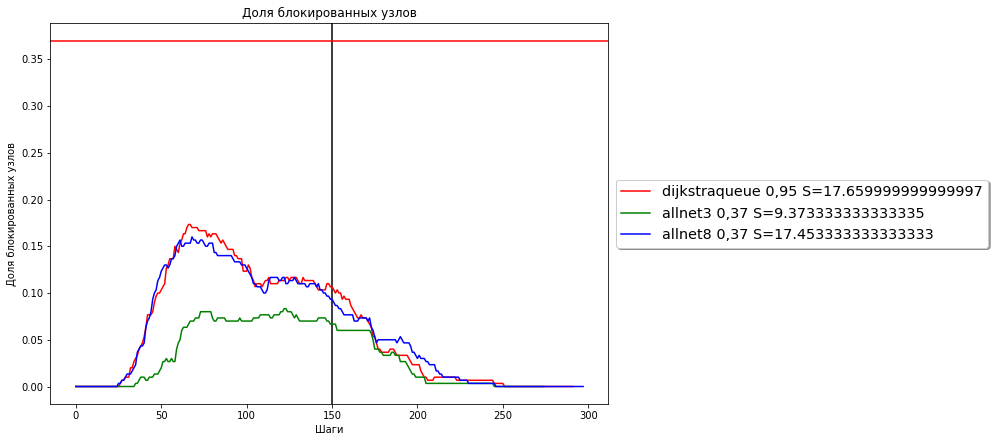

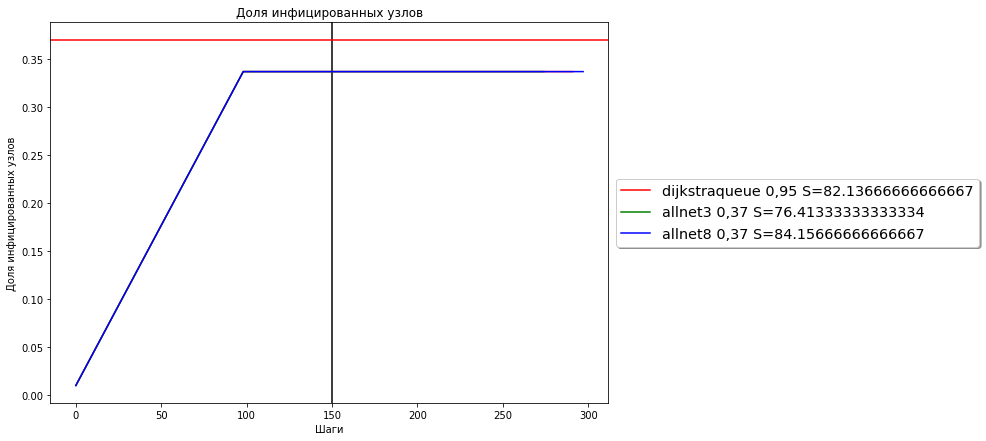

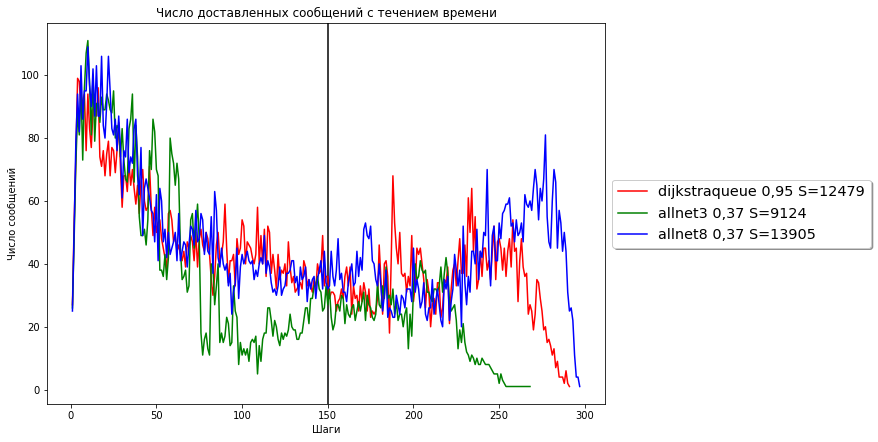

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "cdb02cd5-fc6b-4eb8-a347-2f5db86e5298", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "71daf9bb-204e-4de7-8d14-efdb52cbd9bf", "label": "allnet3 0,37", "color": "green"},
{"tag":  "d236f63f-7c00-4fcd-a027-adc68ae10046", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


<strong>Quantity 1500 </strong>

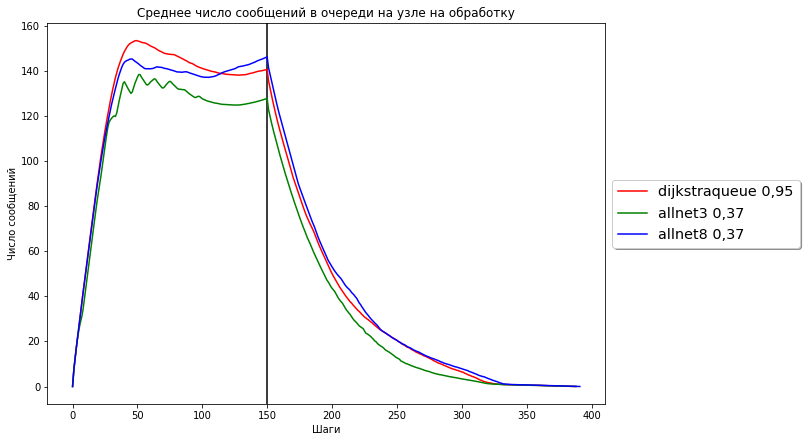

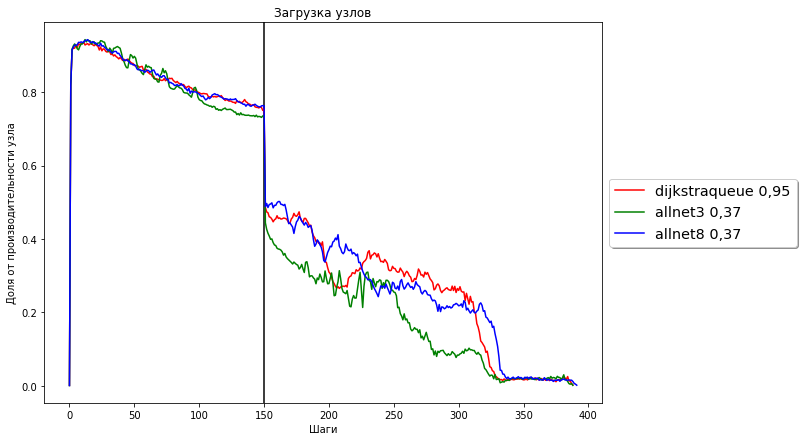

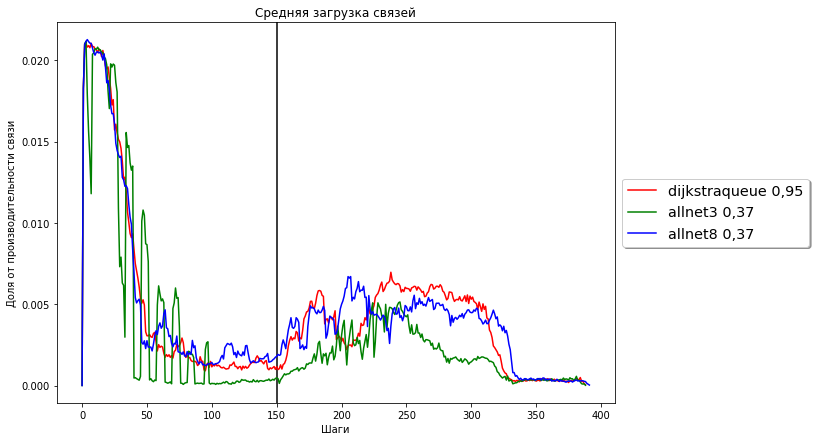

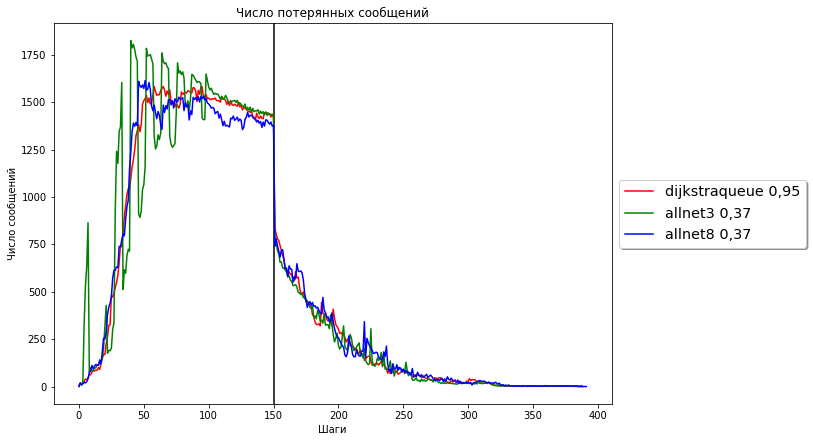

Доставлено 11767 Потеряно 94.7702% -dijkstraqueue 0,95
Доставлено 7751 Потеряно 96.5551% -allnet3 0,37
Доставлено 12499 Потеряно 94.4449% -allnet8 0,37


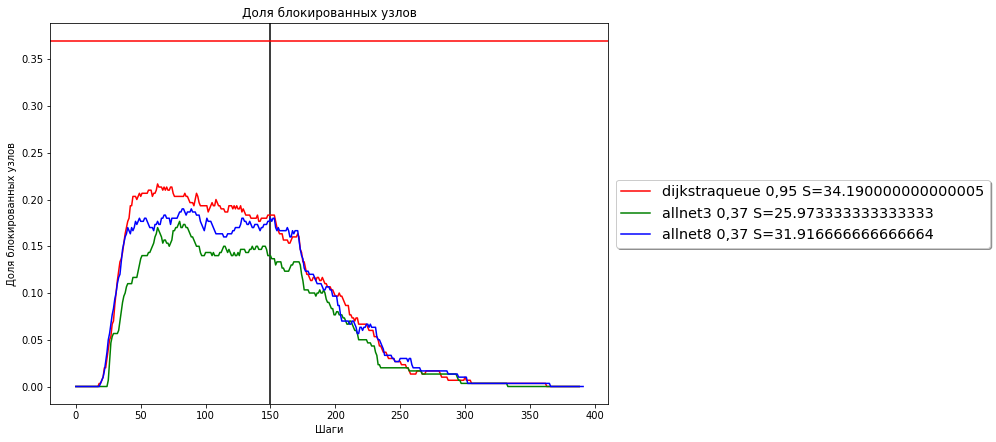

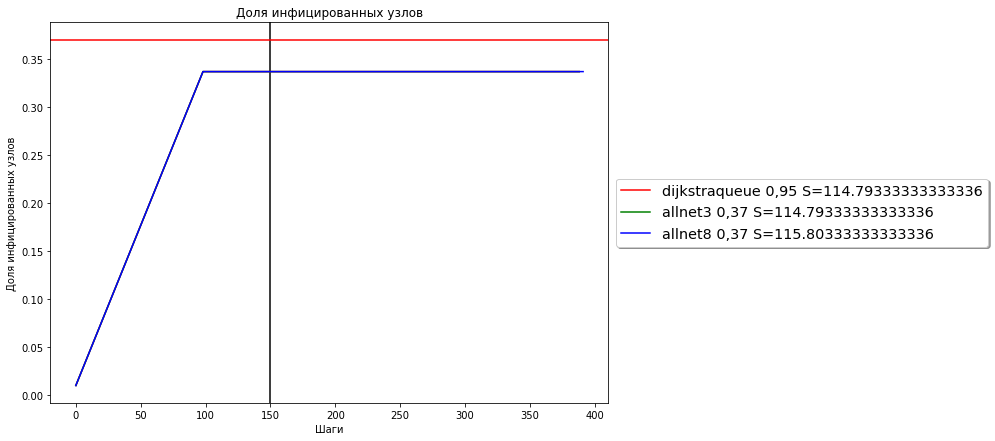

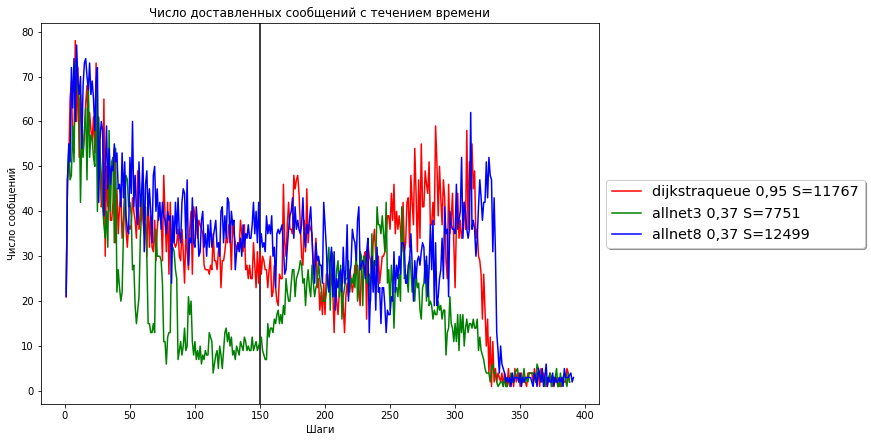

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "8b8b2083-5341-4d1f-8b20-8bac0069b4d8", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "94d94177-9b39-483c-b03c-9d775cef3258", "label": "allnet3 0,37", "color": "green"},
{"tag":  "978d3f23-de88-4cc5-a659-afff50c38236", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();


Доставлено 15969 Потеряно 64.5141% -dijkstraqueue 0,95
Доставлено 11765 Потеряно 73.8561% -allnet3 0,37
Доставлено 19043 Потеряно 57.6832% -allnet8 0,37


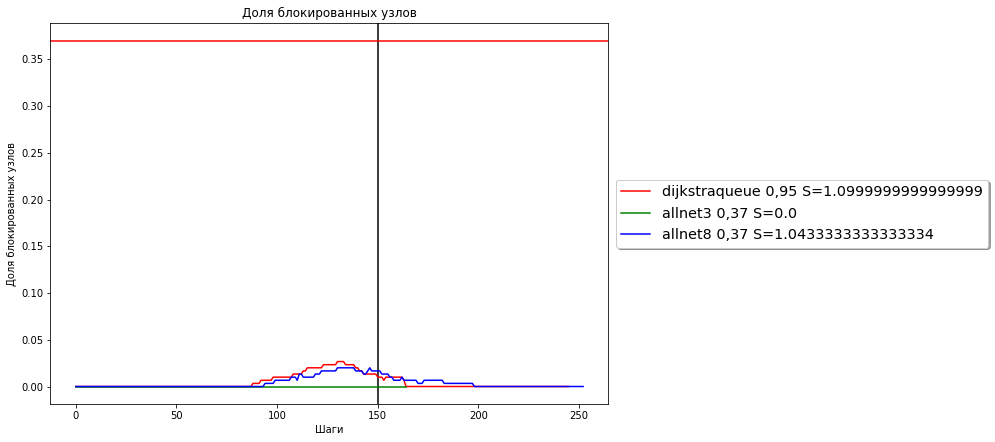

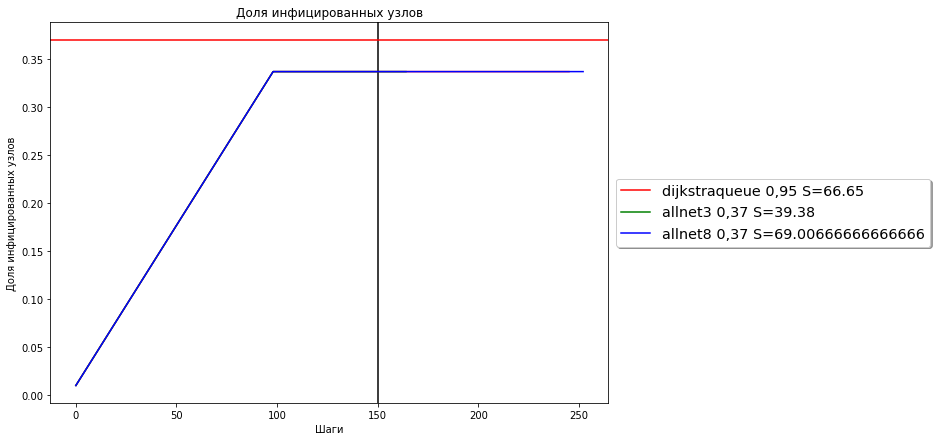

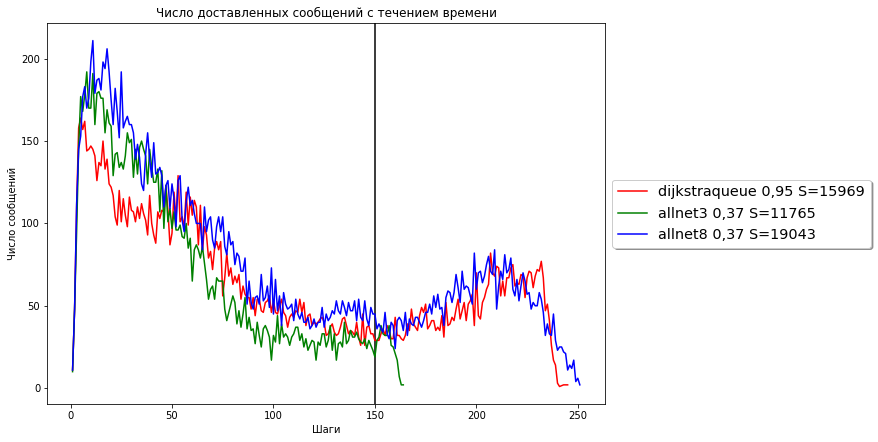

Доставлено 13315 Потеряно 87.3192% -dijkstraqueue 0,95
Доставлено 10839 Потеряно 89.6772% -allnet3 0,37
Доставлено 15197 Потеряно 85.5268% -allnet8 0,37


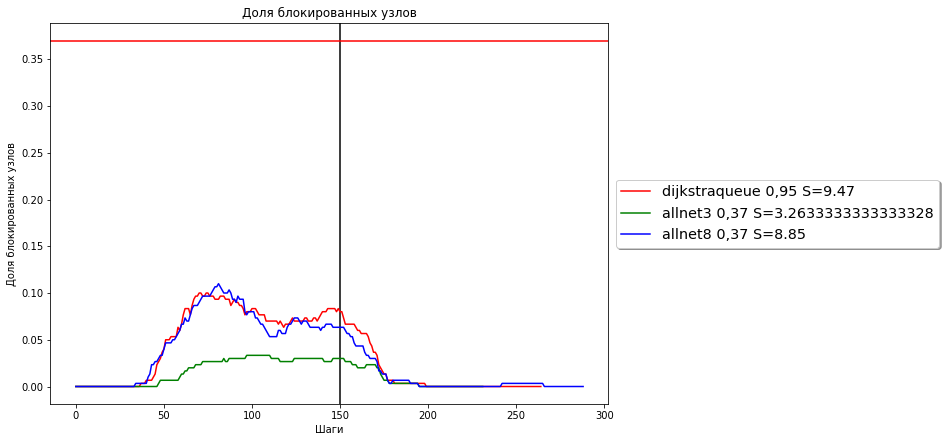

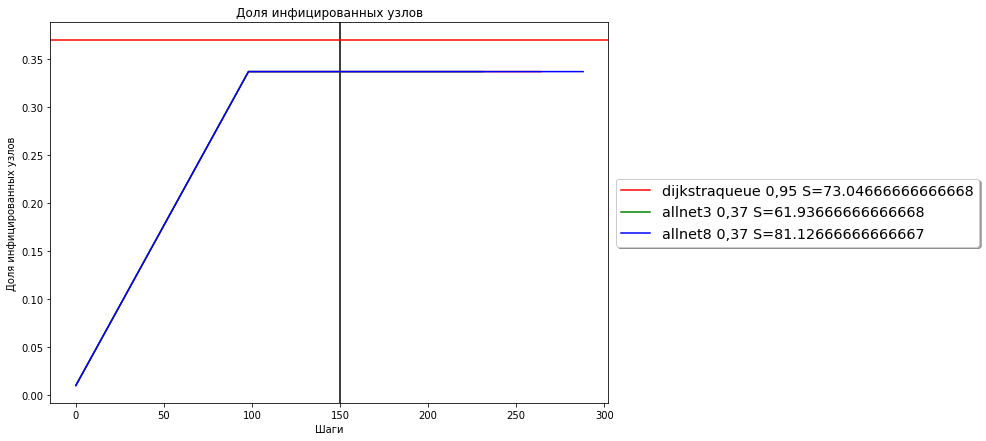

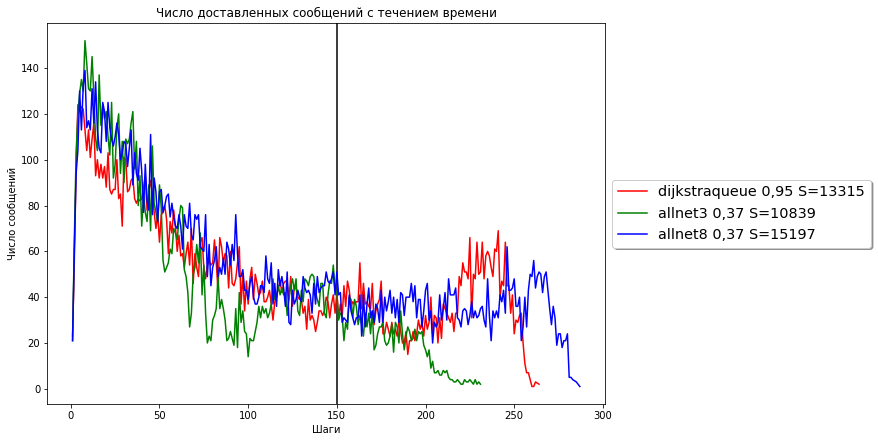

Доставлено 12619 Потеряно 90.6527% -dijkstraqueue 0,95
Доставлено 9199 Потеряно 93.1860% -allnet3 0,37
Доставлено 11636 Потеряно 91.3808% -allnet8 0,37


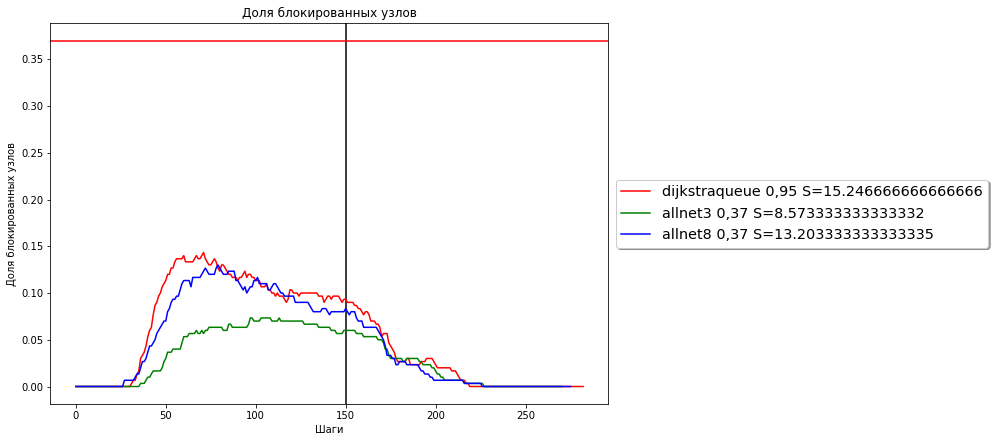

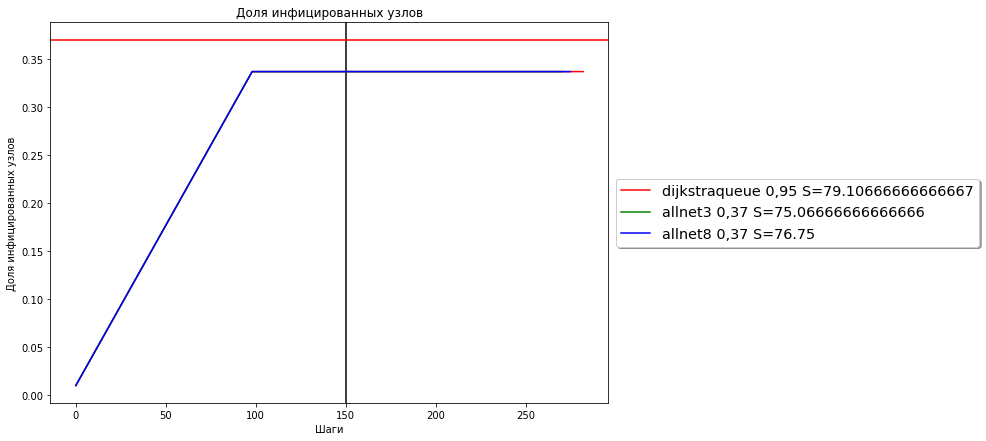

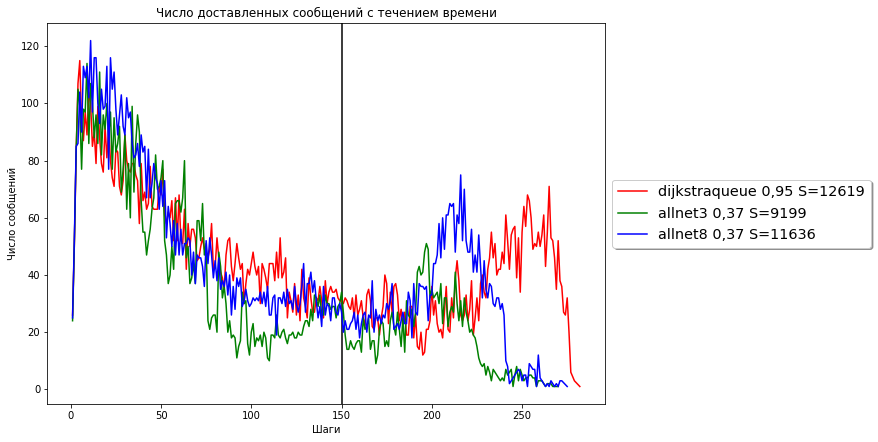

Доставлено 13135 Потеряно 93.2641% -dijkstraqueue 0,95
Доставлено 8011 Потеряно 95.8918% -allnet3 0,37
Доставлено 11836 Потеряно 93.9303% -allnet8 0,37


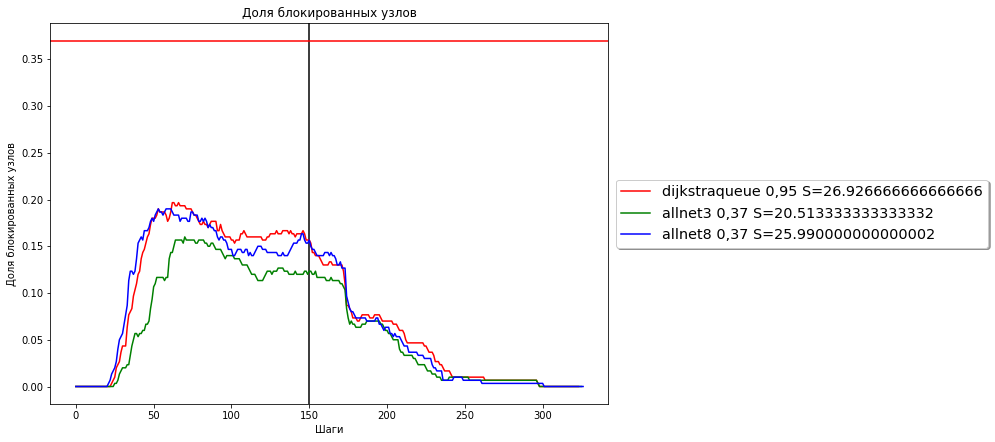

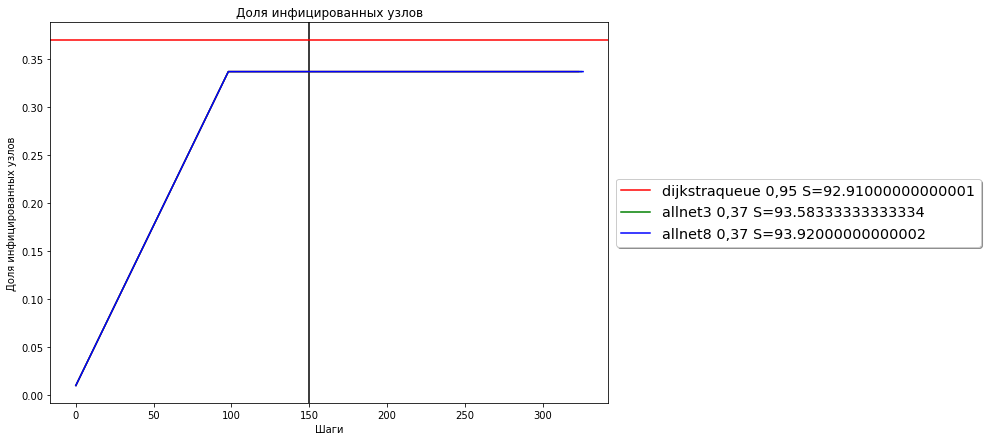

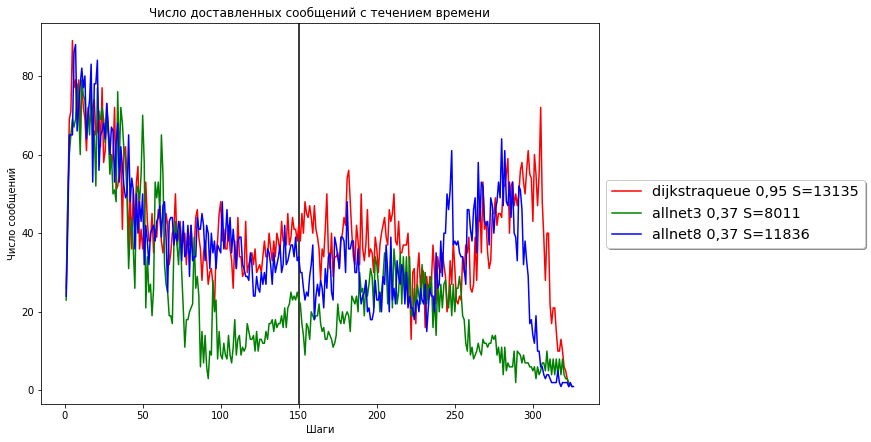

In [7]:
quantity = 300;
log_tags = [
{"tag":  "d3c3267c-3db0-4e71-a343-9e83b306c846", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "95d77d90-0267-45a7-a52b-b313efcd986a", "label": "allnet3 0,37", "color": "green"},
{"tag":  "751f3c52-da54-4d76-a905-ae632cd620a0", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "b6c2c1fe-6541-4343-a6bc-7cfcd69cedf2", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "4e612a72-cfb3-4c92-96f9-2cbaf98972ef", "label": "allnet3 0,37", "color": "green"},
{"tag":  "8f2bf419-e716-4400-8bc5-7841177fd0fc", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "76e1676c-1ef4-4a34-b8b8-51d99119dfe4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "65f61615-0e6b-4302-a20d-5014da5327e8", "label": "allnet3 0,37", "color": "green"},
{"tag":  "aff3f877-77cd-46c2-b4e5-e13eff789228", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "9af16956-cac0-41bb-85fa-dade8cc4c328", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "1f492cf1-1643-47e8-9705-7ce7ec82cfb0", "label": "allnet3 0,37", "color": "green"},
{"tag":  "9af591d5-7b0a-4166-9559-f49c773025b3", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

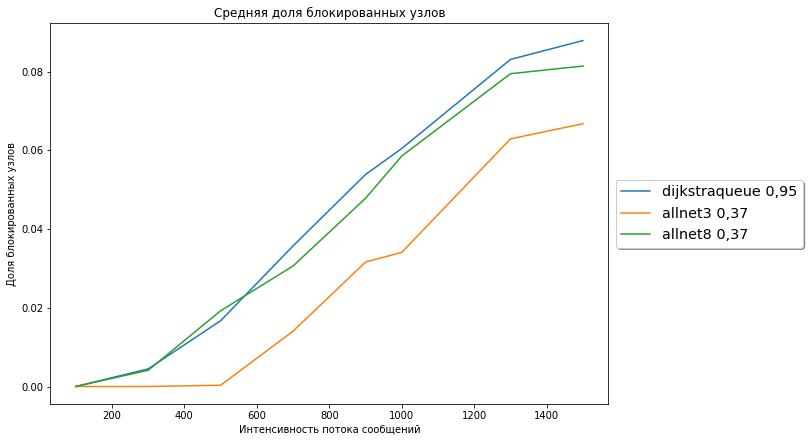

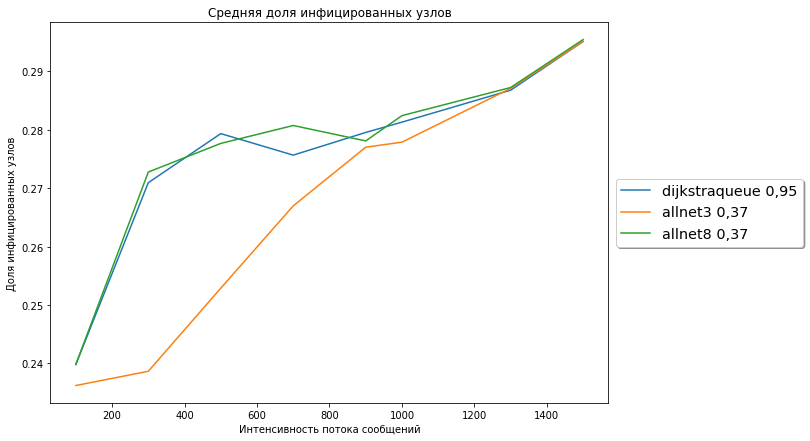

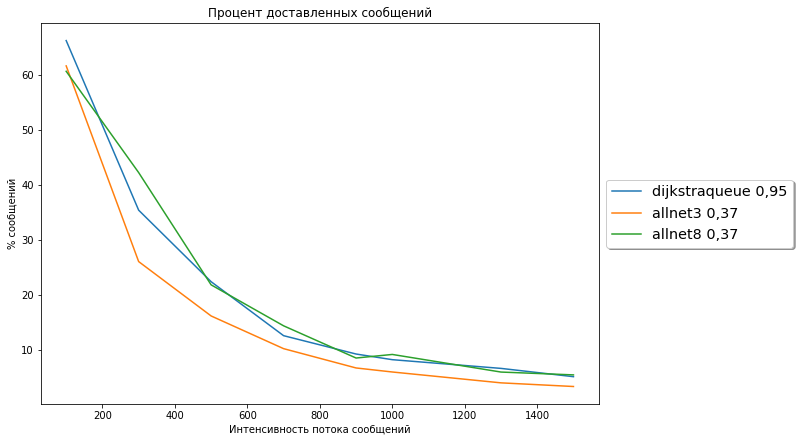

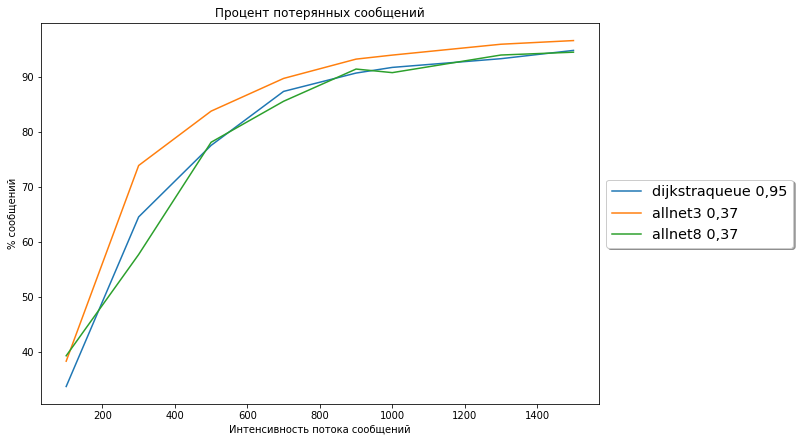

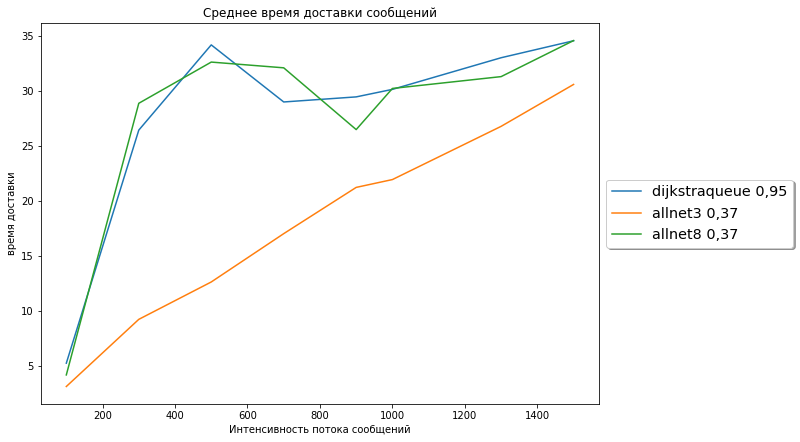

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.042784
allnet3 0,37          0.026226
allnet8 0,37          0.040162

dijkstraqueue 0,95    79.176389
allnet3 0,37          83.139667
allnet8 0,37          78.882047

dijkstraqueue 0,95    27.766521
allnet3 0,37          17.845367
allnet8 0,37          27.557478

dijkstraqueue 0,95    0.276053
allnet3 0,37          0.266473
allnet8 0,37          0.276760
